<a href="https://colab.research.google.com/github/Will170393/MSc-Project---Stance-Detection/blob/master/1_msc_project_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [0]:
# libraries for processing data
import numpy as np
import pandas as pd
import re

# libraries for loading files from drive
from google.colab import drive
drive.mount('/content/gdrive')

# libraries for natural language processing
from nltk import FreqDist, word_tokenize
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
nltk.download('wordnet')

# sklearn libraries for manipulating vectors and results analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# neural network libraries
import tensorflow as tf
from keras import regularizers
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.layers import Dropout, Activation
from keras.utils.np_utils import to_categorical

# libaries to print loss and accuracy graphs
from matplotlib import pyplot as plt

# to get mean value for test results
from statistics import mean 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


**Reading data into panda dataframes and merging Stances and Bodies**

In [0]:
# creates dataframes from reading the stance and body csv files from the google drive, train/test set already split
trainStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_stances.csv')
trainBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_bodies.csv')
testStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_stances.csv')
testBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_bodies.csv')

In [0]:
# merges dataframes for article bodies and article stances, inner merge on the Body ID column that appears in both dataframes
def mergeStances_Bodies(stances, bodies):
  return pd.merge(stances, bodies, how='inner', on='Body ID')

In [0]:
# creates merged training and test dataframes
train = mergeStances_Bodies(trainStances, trainBodies)
test = mergeStances_Bodies(testStances, testBodies)

In [0]:
train.Stance.value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

**Data Cleaning**

Cleaning text in dataframe in preparation for data preprocessing

In [0]:
#removes non-alphabetic characters from strings and make all characters lower case
def data_cleaning(data, col):
  p = re.compile(r'[^\w\s]+')
  data[col] = [p.sub('', str(string)) for string in data[col].tolist()] #uses regex to substitute all non_alphabtic characters with whitespace
  data[col] = [[character.lower() for character in word_tokenize(string)] for string in data[col]] #tokenizes the words and converts characters to lower case
  data[col] = [' '.join(word) for word in data[col]] #rejoin all tokens into single strings                                         

In [0]:
# cleaning dataframes for article Headlines and Bodies
data_cleaning(train, 'Headline')
data_cleaning(train, 'articleBody')
data_cleaning(test, 'Headline')
data_cleaning(test, 'articleBody')

**Data Preprocessing**

In [0]:
#Load pre-defined stops words file from google drive into a list
f = open('gdrive/My Drive/Colab Notebooks/MSC_project_data/project_stopwords_large.txt', encoding='utf-8-sig')
stop_words = f.read().split('\n')
f.close

<function TextIOWrapper.close>

In [0]:
#removing stop words from training and test set
def remove_stop_words(data, col, stop_words):
  filtered_sentence = data[col].apply(lambda text: [word for word in text.split() if word not in stop_words]) # all tokens not in stop words list to filtered_sentence
  data[col] = [' '.join(word) for word in filtered_sentence] #convert column in dataframe into filtered_sentence list                                         

In [0]:
# removing stopwords in dataframes for article Headlines and Bodies
remove_stop_words(train, 'Headline', stop_words)
remove_stop_words(train, 'articleBody', stop_words)
remove_stop_words(test, 'Headline', stop_words)
remove_stop_words(test, 'articleBody', stop_words)

In [0]:
print(stop_words)
train['articleBody'][4680]

["'ll", "'tis", "'twas", "'ve", '10', '39', 'a', "a's", 'able', 'ableabout', 'about', 'above', 'abroad', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'ad', 'added', 'adj', 'adopted', 'ae', 'af', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'ag', 'again', 'against', 'ago', 'ah', 'ahead', 'ai', "ain't", 'aint', 'al', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'alongside', 'already', 'also', 'although', 'always', 'am', 'amid', 'amidst', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ao', 'apart', 'apparently', 'appear', 'appreciate', 'appropriate', 'approximately', 'aq', 'ar', 'are', 'area', 'areas', 'aren', "aren't", 'arent', 'arise', 'around', 'arpa', 'as', 'aside', 'ask', 'asked', 'asking', 'asks', 'associated', 'at', 'au', 'auth', 'available', 'aw', 'away', 'awfully', 'az', 'b', 'ba', 'back', 'backed', 

'catholic priest masschussetts reported dead close hour medics revive shocking revelation return life 71years priest identified father john micheal oneal claims heaven met god describes warm comforting motherly figure presence overwhelming comforting soft soothing voice presence reassuring mothers embrace god holy mother holy father disturb hoped shocking revelation received bit confusion catholic father oneal wishes continue dedicating life god spread word holy mother continue preaching share knowledge mother son holy ghost catholics christians god almighty woman outlook roman catholic archdiocese boston confirm father oneal permitted resume preaching parish south boston father john micheal oneal rushed massachusetts hospital thursday january 29 2015 revived aid hightech machine called lucas 2 blood flowing brain doctors managed unblock vital arteries return heart normal rhythm major heart attack'

**Sampling Data from Training Set**

In [0]:
# methods for upsampling and downsampling data
def upsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  minority_class = dataframe[dataframe.Stance == classification] # set minority class to be all instances of given stance classification
  samples = len(minority_class) # set current samples to be selected to be length of minority class
  
  samples_left = (target_samples - samples) # samples left to select to reach target samples
  
  while (samples_left != 0): #loop until samples left is 0
    
    if(samples_left < samples): # if the samples left to collect is less than currently held sample, set samples to pick to be samples left
      samples = samples_left
  
    minority_class_upsampled = resample(minority_class,
                                        replace = False,
                                        n_samples = samples) #upsample from minority class without replacement
  
    dataframe = dataframe.append(minority_class_upsampled, ignore_index=True) # add new samples to datafrae
    
    samples_left -= samples #reduce the samples_left to collect by number of samples selected
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True) #shuffle dataframe
  
  return dataframe

def downsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  majority_class = dataframe[dataframe.Stance == classification]
  
  majority_class_downsampled = resample(majority_class,
                                        replace = False,
                                        n_samples = target_samples) #downsample to target_sample size
  
  
  dataframe = dataframe[dataframe.Stance != classification] # remove all instances of stance from dataframe
  
  dataframe = dataframe.append(majority_class_downsampled, ignore_index=True) #add in downsample instances of the dataframe
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True) #shuffle dataframe
  
  return dataframe

In [0]:
# creates a unique vocabulary of strings of all unique headlines and articles
def create_unique_vocabulary(dataframe1):
  corpus_strings = set()
  for index, row in dataframe1.iterrows(): #add unique instances of headline and article body into set
    corpus_strings.add(row['Headline'])
    corpus_strings.add(row['articleBody'])
  return list(corpus_strings) #convert set to list

**Defining vectorisation method**

In [0]:
# method to get tfidf vector representation for each document
def get_tfidf_vector(tfidfvectorizer, data):
  return tfidfvectorizer.transform([data]).toarray() #transform document into tfidf vector representation

**Data Processing**
Converting text based representation of data into vector based numerical representations

In [0]:
# method to transform the dat from both headline and artileBody in a feature vector for input into the classification model
def data_processing(dataframe, tfidf_vector_size, vocabulary):
  tfidfvectorizer = TfidfVectorizer(max_features = tfidf_vector_size, use_idf=True).fit(vocabulary)# initialise term frequency inverse document frequency vectorizer with vocabulary passed form the unique vocabulary
  transformed_data = []
  for index, row in dataframe.iterrows(): #iterates through every row in the datframe
    headline = row['Headline'] # set headline variable to be headline in given row in dataframe
    articleBody = row['articleBody'] # set article body variable to be article body in given row in dataframe
    headline_tfidf = get_tfidf_vector(tfidfvectorizer, headline) #uses tfidf vectoriser to get a bag of words representation of headline
    articleBody_tfidf = get_tfidf_vector(tfidfvectorizer, articleBody) #uses tfidf vectoriser to get a bag of words representation of article Body
    tfidf_cos = cosine_similarity(headline_tfidf, articleBody_tfidf) # finds cosine similarity between headline and articlebody bag of words representations
    features = np.squeeze(np.c_[headline_tfidf, articleBody_tfidf, tfidf_cos]) #append all features into a concatenated feature vector
    transformed_data.append(features) #add concatneated feature to data list for input
  transformed_data = np.array(transformed_data) # convert list of data to numpy array
  return transformed_data

In [0]:
# creates folds for cross validation
def dataset_folds(dataset, i, k):
    n = len(dataset)
    return dataset[n*(i-1)//k:n*i//k]

In [0]:
def build_model(input_shape):
  # initialise nueral net
  model = Sequential()

  # add layer with input shape as number of dimensions in feature vectors
  model.add(Dense(2500, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(input_shape,)))
  model.add(Dropout(0.2, noise_shape=None, seed=None))
  model.add(Dense(4, activation='softmax')) #output softmax activation function
  
  return model

In [0]:
# method to initialise MLP, train and test Multi-layer perceptron
def run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, test_df):
  Ytrain = to_categorical(Ytrain, num_classes = 4)
  Ytest = to_categorical(Ytest, num_classes = 4)
  
  # define parameters to compile model
  model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])
  
  # print loss/accuracy graphs
  for i in range(1):
    history = model.fit(Xtrain, Ytrain, epochs = 3, validation_split=0.2, shuffle=True)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # test model
    test_loss, test_acc = model.evaluate(Xtest, Ytest)
    print(test_loss, test_acc)
    
    Ypred = model.predict(Xtest)
    Ypred_bool = np.argmax(Ypred, axis=1)

    Ytest = test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
    
    # print classification report
    print(classification_report(Ytest, Ypred_bool))
    
    # print confusion matrix
    print(confusion_matrix(Ytest, Ypred_bool))
    
    # return test accuracy
    return test_acc
  

In [0]:
# append all dat together
all_data = train.append(test)

In [0]:
all_data.Stance.value_counts()

unrelated    54894
discuss      13373
agree         5581
disagree      1537
Name: Stance, dtype: int64

In [0]:
print(len(all_data))

75385


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
W0902 10:36:20.200102 140299347322752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 10:36:20.222653 140299347322752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10908
           1       0.49      0.60      0.54       334
           2       0.85      0.89      0.87      2682
           3       0.69      0.73      0.71      1153

    accuracy                           0.93     15077
   macro avg       0.76      0.80      0.78     15077
weighted avg       0.93      0.93      0.93     15077

[[10553    28   197   130]
 [    8   200    50    76]
 [   65    75  2376   166]
 [   39   102   167   845]]


W0902 10:36:20.480746 140299347322752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 360s 7ms/step - loss: 1.5075 - acc: 0.6858 - val_loss: 1.3186 - val_acc: 0.7021
Epoch 2/3
48000/48000 [==============================] - 358s 7ms/step - loss: 1.2162 - acc: 0.7213 - val_loss: 1.1604 - val_acc: 0.7199
Epoch 3/3
48000/48000 [==============================] - 357s 7ms/step - loss: 1.1057 - acc: 0.7407 - val_loss: 1.0666 - val_acc: 0.7362


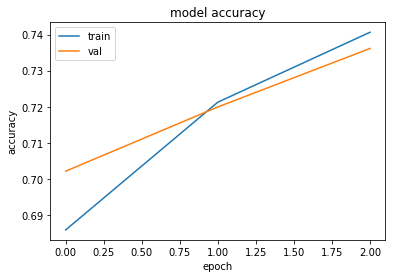

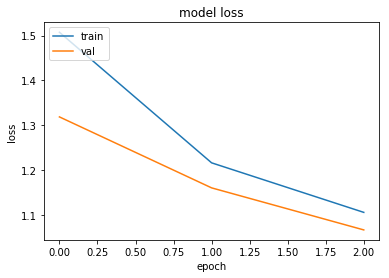

15077/15077 [==============================] - 18s 1ms/step
0.7055332982418367 0.8947403329574849
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     10908
           1       0.36      0.57      0.44       334
           2       0.81      0.73      0.77      2682
           3       0.58      0.60      0.59      1153

    accuracy                           0.89     15077
   macro avg       0.68      0.72      0.69     15077
weighted avg       0.90      0.89      0.90     15077

[[10652    37   160    59]
 [   25   190    54    65]
 [  207   144  1959   372]
 [   72   150   242   689]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10966
           1       0.47      0.58      0.52       297
           2       0.85      0.88      0.87      2707
           3       0.67      0.76      0.71      1107

    accuracy                           0.93     15077
   macro avg       0.75      0.80      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10579    28   220   139]
 [    8   172    49    68]
 [   64    61  2384   198]
 [   28   104   137   838]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 356s 7ms/step - loss: 1.5118 - acc: 0.6830 - val_loss: 1.2180 - val_acc: 0.7165
Epoch 2/3
48000/48000 [==============================] - 354s 7ms/step - loss: 1.2175 - acc: 0.7214 - val_loss: 1.1783 - val_acc: 0.7420
Epoch 3/3
48000/48000 [==============================] - 353s 7ms/step - loss: 1.0996 - acc: 0.7407 - val_loss: 1.0081 - val_acc: 0.

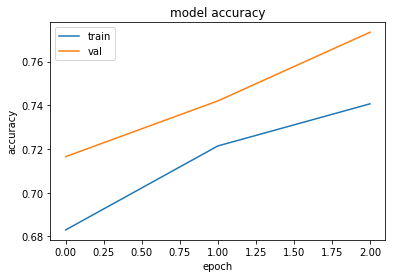

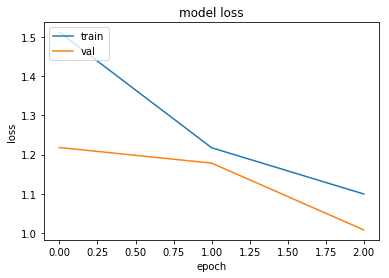

15077/15077 [==============================] - 19s 1ms/step
0.7511552934930615 0.8814087683265639
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10966
           1       0.26      0.68      0.38       297
           2       0.81      0.70      0.75      2707
           3       0.56      0.58      0.57      1107

    accuracy                           0.88     15077
   macro avg       0.65      0.73      0.67     15077
weighted avg       0.90      0.88      0.89     15077

[[10540    83   209   134]
 [   19   202    43    33]
 [  201   268  1903   335]
 [   62   211   190   644]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11010
           1       0.48      0.56      0.52       291
           2       0.86      0.88      0.87      2665
           3       0.68      0.76      0.72      1111

    accuracy                           0.93     15077
   macro avg       0.75      0.79      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10638    18   206   148]
 [   11   164    39    77]
 [   69    79  2340   177]
 [   37    78   148   848]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 354s 7ms/step - loss: 1.5080 - acc: 0.6858 - val_loss: 1.2781 - val_acc: 0.7007
Epoch 2/3
48000/48000 [==============================] - 353s 7ms/step - loss: 1.2177 - acc: 0.7169 - val_loss: 1.1850 - val_acc: 0.7173
Epoch 3/3
48000/48000 [==============================] - 353s 7ms/step - loss: 1.0983 - acc: 0.7390 - val_loss: 1.0175 - val_acc: 0.

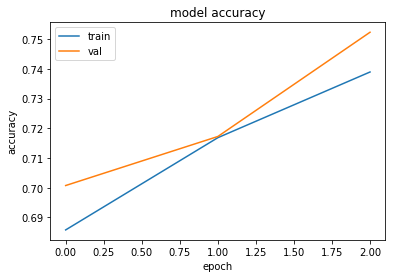

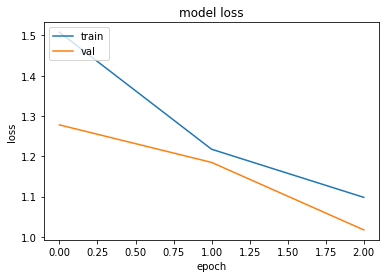

15077/15077 [==============================] - 18s 1ms/step
0.7259382036665734 0.8848577303177024
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11010
           1       0.29      0.55      0.38       291
           2       0.77      0.77      0.77      2665
           3       0.57      0.60      0.58      1111

    accuracy                           0.88     15077
   macro avg       0.65      0.72      0.68     15077
weighted avg       0.90      0.88      0.89     15077

[[10453    69   353   135]
 [   19   161    41    70]
 [  144   160  2062   299]
 [   54   158   234   665]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10937
           1       0.50      0.57      0.53       312
           2       0.86      0.88      0.87      2682
           3       0.69      0.76      0.72      1146

    accuracy                           0.93     15077
   macro avg       0.76      0.79      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10604    18   188   127]
 [    7   179    42    84]
 [   78    73  2347   184]
 [   32    90   158   866]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 363s 8ms/step - loss: 1.5066 - acc: 0.6872 - val_loss: 1.2295 - val_acc: 0.7121
Epoch 2/3
48000/48000 [==============================] - 362s 8ms/step - loss: 1.2221 - acc: 0.7182 - val_loss: 1.1706 - val_acc: 0.7281
Epoch 3/3
48000/48000 [==============================] - 361s 8ms/step - loss: 1.1041 - acc: 0.7390 - val_loss: 1.0647 - val_acc: 0.

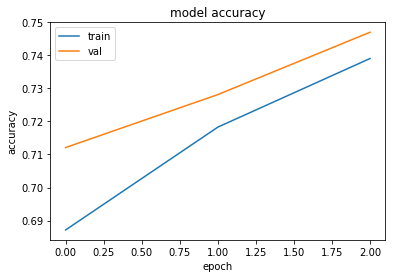

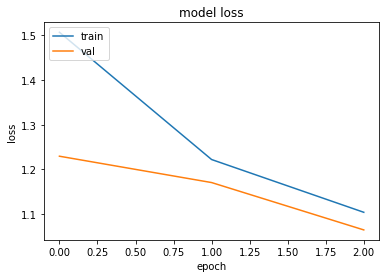

15077/15077 [==============================] - 19s 1ms/step
0.7795057546841795 0.8772302182131724
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10937
           1       0.29      0.60      0.39       312
           2       0.79      0.72      0.75      2682
           3       0.53      0.57      0.55      1146

    accuracy                           0.88     15077
   macro avg       0.65      0.71      0.66     15077
weighted avg       0.89      0.88      0.88     15077

[[10456   102   228   151]
 [   22   188    49    53]
 [  207   182  1932   361]
 [   61   183   252   650]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11073
           1       0.48      0.57      0.52       303
           2       0.86      0.87      0.87      2637
           3       0.66      0.72      0.69      1064

    accuracy                           0.93     15077
   macro avg       0.75      0.78      0.76     15077
weighted avg       0.93      0.93      0.93     15077

[[10761    23   182   107]
 [    7   173    38    85]
 [   80    56  2303   198]
 [   49   108   146   761]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 364s 8ms/step - loss: 1.5155 - acc: 0.6868 - val_loss: 1.2952 - val_acc: 0.7006
Epoch 2/3
48000/48000 [==============================] - 363s 8ms/step - loss: 1.2205 - acc: 0.7192 - val_loss: 1.1204 - val_acc: 0.7418
Epoch 3/3
48000/48000 [==============================] - 364s 8ms/step - loss: 1.0969 - acc: 0.7412 - val_loss: 1.0497 - val_acc: 0.

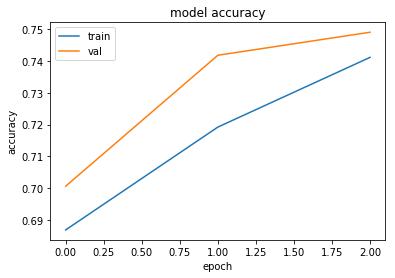

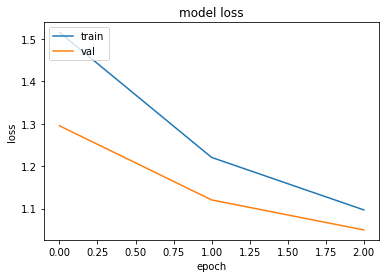

15077/15077 [==============================] - 18s 1ms/step
0.8202468989706169 0.8662200703097171
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     11073
           1       0.28      0.71      0.40       303
           2       0.77      0.70      0.74      2637
           3       0.46      0.58      0.51      1064

    accuracy                           0.87     15077
   macro avg       0.62      0.73      0.65     15077
weighted avg       0.89      0.87      0.88     15077

[[10379   125   342   227]
 [   15   214    25    49]
 [  134   205  1846   452]
 [   57   216   170   621]]


In [0]:
# train and test models using cross validation across folds of data
stances = ['unrelated', 'disagree', 'discuss', 'agree'] #stances list initialised to be loop through
column_names =  ['Headline', 'Body ID', 'Stance', 'articleBody']
all_data = all_data.sample(frac=1).reset_index(drop=True) #shuffle dataframe
accuracy_scores_rf = []
accuracy_scores_mlp = []
for i in range(5): #5-folds of cross-validation
  rf = RandomForestClassifier()
  model = build_model(5001)
  kFold_train_df = all_data.iloc[0:0] #empty dataframe for training
  kFold_test_df = all_data.iloc[0:0] #empty dataframe for testing
  for j in range(4): # 4 training folds
    train_fold = dataset_folds(all_data,((i+j)%5)+1,5) #use modulo to get different combination of folds of data for training split each iteration
    kFold_train_df = pd.concat([kFold_train_df,train_fold]) #concatenate all training folds
  test_fold = dataset_folds(all_data,((i+4)%5)+1,5) #get the remaining fold for the test data, different fold every iteration
  kFold_test_df = pd.concat([kFold_test_df,test_fold]) #concatenate test fold onto test dataframe
  for stance in stances: #re-sample all stances
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) == 0):#if training data contains no instances of the given stance, skip to next
      continue;              
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) < 15000):# if less than 15000 observations of given stance, downsample
      kFold_train_df = upsample_data(kFold_train_df, str(stance), 15000)
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) > 15000): # if more tha 15000 observations of given stance, upsample
      kFold_train_df = downsample_data(kFold_train_df, str(stance), 15000)
  vocab = create_unique_vocabulary(kFold_train_df) #create vocabulary for each training set
  Xtrain = data_processing(kFold_train_df, 2500, vocab) #process training set
  Xtest = data_processing(kFold_test_df, 2500, vocab) # process test set
  Ytrain = kFold_train_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3}) #create mappings from stance classification to numerical values
  Ytest = kFold_test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  rf = rf.fit(Xtrain, Ytrain) #train random forest
  Ypred = rf.predict(Xtest) # test random forest
  rf_score = accuracy_score(Ytest, Ypred) # get random forest accuracy score
  accuracy_scores_rf.append(rf_score)
  print(classification_report(Ytest, Ypred)) # get classification report for random forest
  print(confusion_matrix(Ytest, Ypred)) # get confusion matrix for random forest
  mlp_score = run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, kFold_test_df) #train and test mlp
  accuracy_scores_mlp.append(mlp_score)

In [0]:
print(mean(accuracy_scores_rf))
print(mean(accuracy_scores_mlp))

0.9276513895337268
0.8808914240249281
